In [1]:
import pandas

In [2]:
tables = pandas.read_html('https://en.wikipedia.org/wiki/List_of_oil_spills')

In [4]:
len(tables)

11

In [5]:
tables[0]

,Spill / Vessel,Location,Dates,Min Tonnes,Max Tonnes,Owner,Link(s)
0,2020 Pointe D'Esny MV Wakashio oil spill,"Mauritius, Ile Aux Aigrettes and Mahebourg",25 July 2020,1300,4300,"Wakashio Suisan Company Limited, Kagoshima, Japan",[1] [2]
1,Trans Mountain oil spill,"Canada, British Columbia, Abbotsford",14 June 2020,118.5,184.87,Trans Mountain,[3]
2,Norilsk diesel fuel spill,"Russia, Norilsk, Krasnoyarsk Krai",29 May 2020,17500,17500,Nornickel,[4][5]
3,Tanker truck pumping out sludge from a vessel,"New Zealand, Tauranga, Bay of Plenty",30 March 2020,1.7,1.7,NaN,[6][7]
4,T.G. Williams Well No. 1 tank battery,"United States, Oakland Creek, Longview",30 March 2020,unknown,unknown,Fortune Resources,[8]
...,...,...,...,...,...,...,...
255,Scuttled tanker El Grillo,"Iceland, Seyðisfjörður",February 1944 – present,unknown,unknown,NaN,[300]
256,SS Frank H. Buck / SS President Coolidge colli...,"United States, San Francisco Bay, California",6 March 1937,8870,8870,NaN,[273][301]
257,Lakeview Gusher,"United States, Kern County, California",14 March 1910 – 10 September 1911,1230000,1230000,NaN,[302]
258,Thomas W. Lawson,"United Kingdom, Isles of Scilly",14 December 1907,7400,7400,NaN,[303]


In [6]:
float('unkown')

ValueError: could not convert string to float: 'unkown'

In [7]:
def robust_float(x):
    try:
        return float(x)
    except ValueError:
        return float('nan')

In [8]:
tonnes = tables[0]['Max Tonnes'].apply(robust_float)

In [9]:
import re

In [14]:
int(re.search('\d{4}', "30 March 2020").group())

2020

In [10]:
y = tables[0]['Dates'].apply(lambda x: int(re.search('\d{4}', x).group()))

In [15]:
total_tonnes = tonnes.groupby(y).sum()

In [16]:
total_tonnes = total_tonnes[total_tonnes.index > 1970]

<AxesSubplot:xlabel='Dates'>

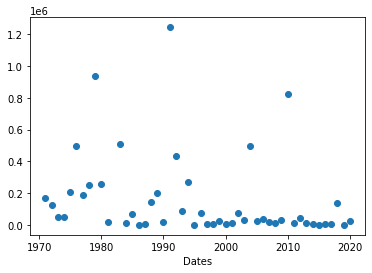

In [18]:
total_tonnes.plot(marker='o', ls='')

In [19]:
spills = y.groupby(y).size()

In [21]:
spills = spills[spills.index > 1970]

<AxesSubplot:xlabel='Dates'>

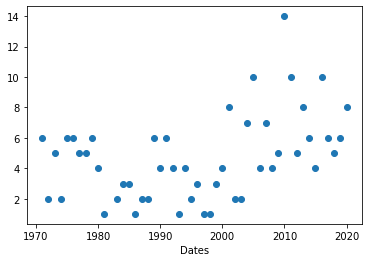

In [27]:
spills.plot(marker='o', ls='')

In [30]:
years = spills.index

In [29]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

In [121]:
def spill_count_model(rate_fn):
    count_model = tfd.JointDistributionNamed({
        "e": tfd.Exponential(rate=1.0),
        "l": tfd.Exponential(rate=1.0),
        "s": tfd.Uniform(float(years.min()), float(years.max())),
        "d_t": lambda s, l, e: tfd.Independent(
            tfd.Poisson(rate = rate_fn(
                tf.constant(years, dtype=tf.float32),
                s[...,tf.newaxis], l[...,tf.newaxis], e[...,tf.newaxis])
            ),
        reinterpreted_batch_ndims=1)
    })
    return count_model

In [47]:
tf.where([True, True, False], 1, 12)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 1,  1, 12], dtype=int32)>

In [95]:
def rate_fn_switch(years, s, l, e):
    return tf.where(years < s, e, l)

In [96]:
def rate_fn_sigmoid(years, s, l, e):
    return e + tf.sigmoid(years - s) * (l - e)

In [113]:
rate_fn_switch(years, 1990, 10, 1)

<tf.Tensor: shape=(49,), dtype=int32, numpy=
array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
      dtype=int32)>

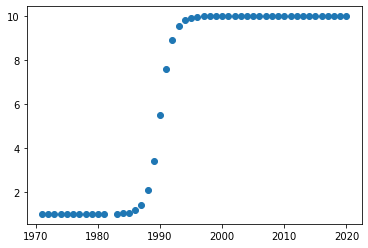

In [118]:
plt.plot(years, rate_fn_sigmoid(years, 1990., 10, 1).numpy(), marker='o', ls='')

In [122]:
model_switch = spill_count_model(rate_fn_switch)
model_sigmoid = spill_count_model(rate_fn_sigmoid)

In [111]:
model_sigmoid.resolve_graph()

(('s', ()), ('l', ()), ('e', ()), ('d_t', ('s', 'l', 'e')))

In [50]:
import matplotlib.pyplot as plt

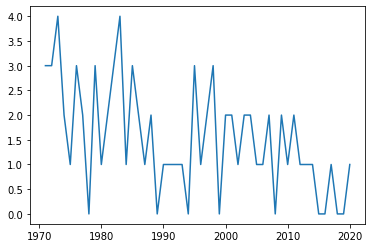

In [51]:
plt.plot(years, model_switch.sample()['d_t'])

In [52]:
def target_log_prob(model, s, e, l):
    return model.log_prob(s=s, e=e, l=l, d_t=spills)

In [53]:
target_log_prob(model_switch, 2000, 4, 8)

<tf.Tensor: shape=(), dtype=float32, numpy=-127.52641>

# MAP estimate

In [69]:
s, e, l = tf.Variable(1990.), tf.Variable(1.0), tf.Variable(1.0)

In [76]:
loss = lambda: -target_log_prob(model_sigmoid, s, e, l)

In [77]:
loss()

<tf.Tensor: shape=(), dtype=float32, numpy=300.3353>

In [78]:
opt = tf.optimizers.SGD(learning_rate=0.2)
loss_hist = []
var_hist = {v: [] for v in ['s', 'e', 'l']}
for _ in range(50):
    opt.minimize(loss, [s, e, l])
    loss_hist.append(loss().numpy())
    var_hist['e'].append(e.numpy())    
    var_hist['s'].append(s.numpy())    
    var_hist['l'].append(l.numpy())    

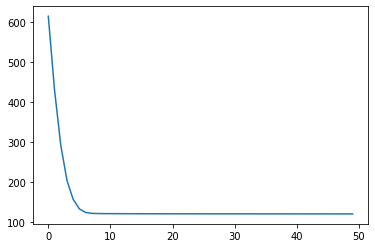

In [79]:
plt.plot(loss_hist)

In [80]:
s, e, l

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2002.2244>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.3495784>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=6.461434>)

# Refresher

In [82]:
thetas = tf.linspace(0.0, 1.0, 50)
simple_model = tfd.Binomial(total_count=50, probs=thetas)

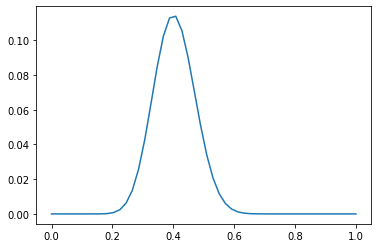

In [84]:
plt.plot(thetas, simple_model.prob(20))

In [86]:
es = tf.linspace(2., 5., 20)
ls = tf.linspace(5., 10., 20)
switches = tf.linspace(1990., 2010., 20)

In [87]:
grid = tf.meshgrid(switches, es, ls)

In [90]:
tf.reshape(grid[0], [-1])

<tf.Tensor: shape=(8000,), dtype=float32, numpy=array([1990., 1990., 1990., ..., 2010., 2010., 2010.], dtype=float32)>

In [98]:
log_probs = target_log_prob(model_sigmoid, *[tf.reshape(grid[i], [-1]) for i in range(3)])

In [99]:
log_probs = tf.reshape(log_probs, [20]*3)

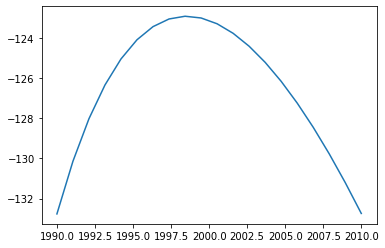

In [100]:
plt.plot(switches, log_probs[:,10,10])

In [101]:
es[10], ls[10]

(<tf.Tensor: shape=(), dtype=float32, numpy=3.5789473>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.631579>)

In [102]:
es[5], ls[15]

(<tf.Tensor: shape=(), dtype=float32, numpy=2.7894735>,
 <tf.Tensor: shape=(), dtype=float32, numpy=8.947369>)

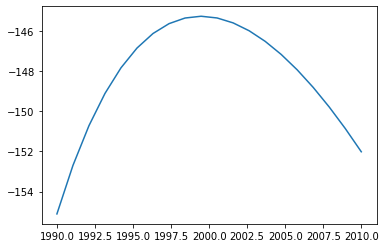

In [103]:
plt.plot(switches, log_probs[:,5,15])

In [107]:
tf.reduce_max(log_probs)

<tf.Tensor: shape=(), dtype=float32, numpy=-119.74767>

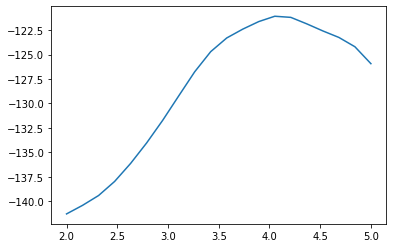

In [108]:
plt.plot(es, log_probs[10,:,10])

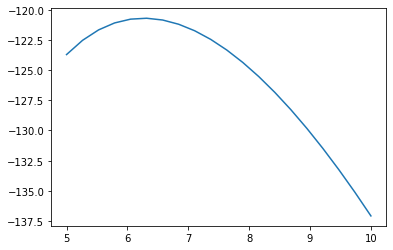

In [109]:
plt.plot(ls, log_probs[10,10,:])